
1. During the early days of the covid 19 pandemic, many scientists from arround the world turned to their prefered modeling tools to provide insight into how the pandemic might unfold and what actions governments should take. One particular model which made headlines around the globe was developed by a group at Imperial in the UK. This model was derived from an earlier 2005 model for Thailand to study how a mutated version of H5N1 avian flu might spread. In follow up work, the authors reparameterized this model for the UK to study possible deadly flu strains. Without going into the specifics of the imperial model, what can you say more theoretically about the strengths and weaknesses of using ABMs to study pandemic outbreaks at a country level?


2. The model below contains 5 errors. Fix the model. Carefull list each error, the line number and how you have changed it.

* line 56 agent_reporter should be model_reporter
* line 65, 66 should be self.random
* line 66
* line 124

3. Below, the image shows an alternative implementation of the Schelling seggregation model using hexagonal tiling. If you were asked to implement this version of the model, how woud you do it?

<img src="fig_hex_300dpi.png" width="400">

4. A major structural uncertainty in the Schelling segregration model is what counts as the neighborhood of the model. Focus specifically on the number of ticks it takes for the model to reach equilibrium with a maximum of 100 ticks. In answering this question, first conceptually describe what needs to be done for answering this question, before implementing it. 
    
    1. How does the behavior of the model change depending on whether you are using von Neuman or Moore? 
    2.And what happens to the behavior of the model if you change the radius (1, 2, or 3) in case of a Moore neighborhood? 
    3. Offer an explanation for the results

In [16]:
import random

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector

from enum import Enum

class Color(Enum):
    RED = 1 # minority color
    BLUE = 2 # majority color

def count_happy(model):
    happy = 0
    for agent in model.schedule.agents:
        if agent.happy:
            happy += 1
    return happy

class Schelling(Model):
    """
    Model class for the Schelling segregation model.
    
    Parameters
    ----------
    height : int
             height of grid
    width : int
            height of width
    density : float
            fraction of grid cells occupied
    minority_fraction : float
            fraction of agent of minority color
    tolerance_threshold : float
                          fraction of differently colored neighbors
                          which is acceptable
    
    Attributes
    ----------
    density : float
    minority_fraction : float
    schedule : RandomActivation instance
    grid : SingleGrid instance
    
    """

    def __init__(self, height=20, width=20, density=0.8, minority_fraction=0.2,
                 tolerance_threshold=0.5, seed=None):
        super().__init__(seed=seed)
        self.density = density
        self.minority_fraction = minority_fraction

        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(width, height, torus=True)
        self.datacollector = DataCollector(model_reporters={'happy':count_happy})

        # Set up agents
        # We use a grid iterator that returns
        # the coordinates of a cell as well as
        # its contents. (coord_iter)
        for cell in self.grid.coord_iter():
            x = cell[1]
            y = cell[2]
            if self.random.random() < self.density:
                if self.random.random() <= self.minority_fraction:
                    agent_color = Color.RED
                else:
                    agent_color = Color.BLUE

                agent = SchellingAgent((x, y), self, agent_color, tolerance_threshold)
                self.grid.position_agent(agent, (x, y))
                self.schedule.add(agent)

    def step(self):
        """
        Run one step of the model.
        """
        self.schedule.step()
        self.datacollector.collect(self)


class SchellingAgent(Agent):
    """
    Schelling segregation agent
    
    Parameters
    ----------
    pos : tuple of 2 ints
          the x,y coordinates in the grid
    model : Model instance
    color : {Color.RED, Color.BLUE}
    tolerance_threshold : float
    
    Attributes
    ----------
    pos : tuple
    color : Color field
    tolerance_threshold : float
    happy : boolean
    
    """

    def __init__(self, pos, model, color, tolerance_threshold):
        super().__init__(pos, model)
        self.pos = pos
        self.color = color
        self.tolerance_threshold = tolerance_threshold
        self.happy = True
        
    def meets_threshold(self):
        different = 0
        neighborhood_iterator = self.model.grid.iter_neighborhood(self.pos, moore=True,
                                                                  radius=1)
        neighborhood_pos = [entry for entry in neighborhood_iterator]
        neighborhood_size = len(neighborhood_pos)
        
        neighborhood = self.model.grid.iter_cell_list_contents(neighborhood_pos)                
        
        for neighbor in neighborhood:
            if neighbor.color != self.color:
                different += 1
        
        meets_threshold = different < (self.tolerance_threshold * neighborhood_size)
        return meets_threshold

    def step(self):
        '''execute one step of the agent'''
        
        if not self.meets_threshold():
            self.model.grid.move_to_empty(self)
            self.happy = False
        else:
            self.happy = True
            
            
model = Schelling()


In [17]:
model = Schelling()

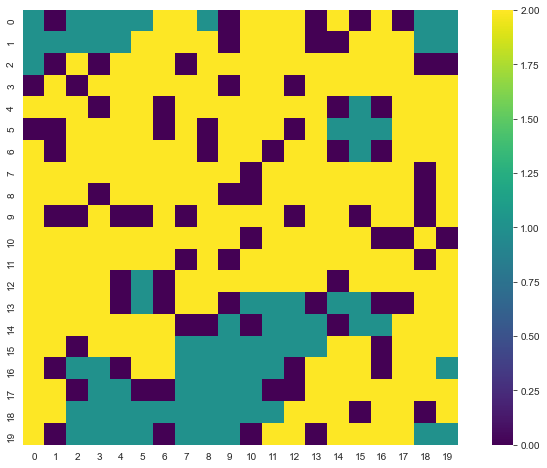

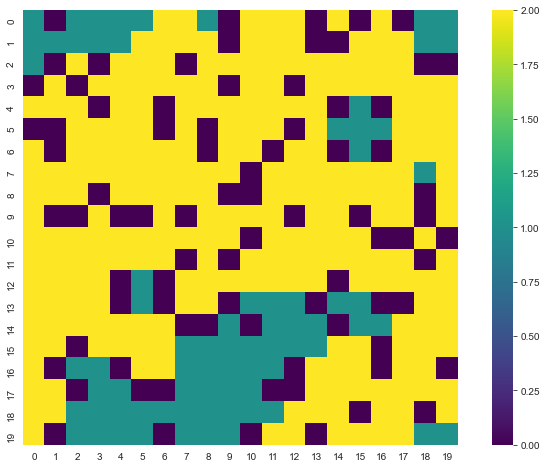

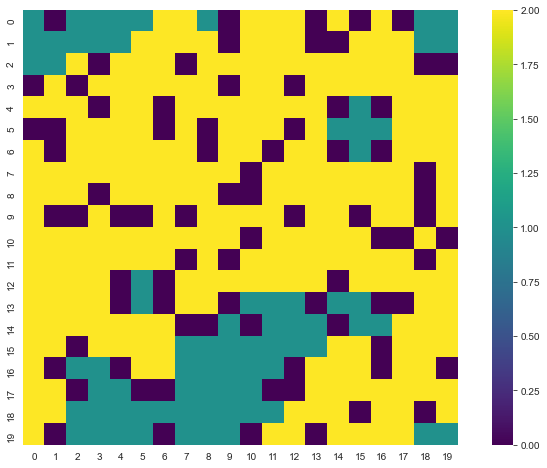

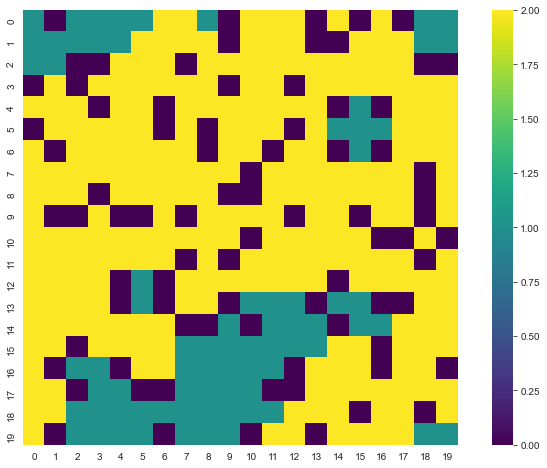

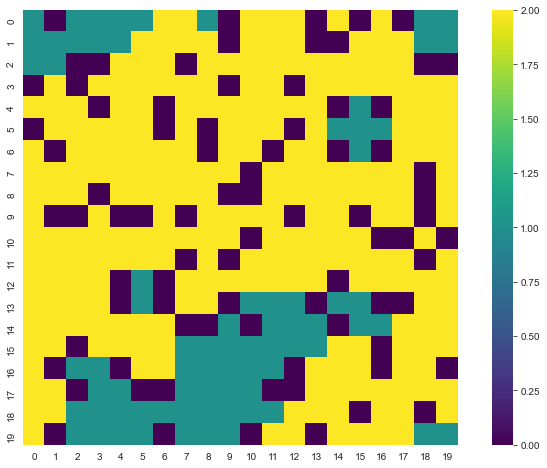

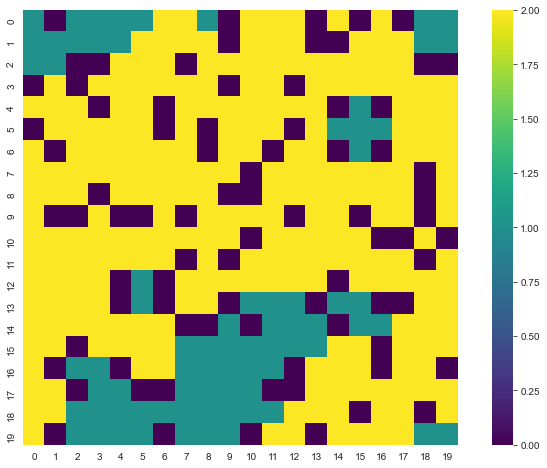

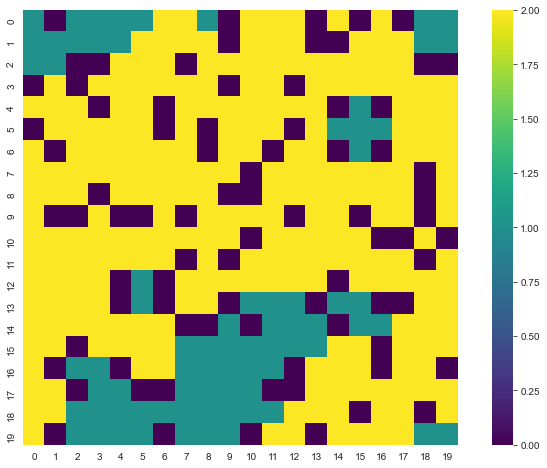

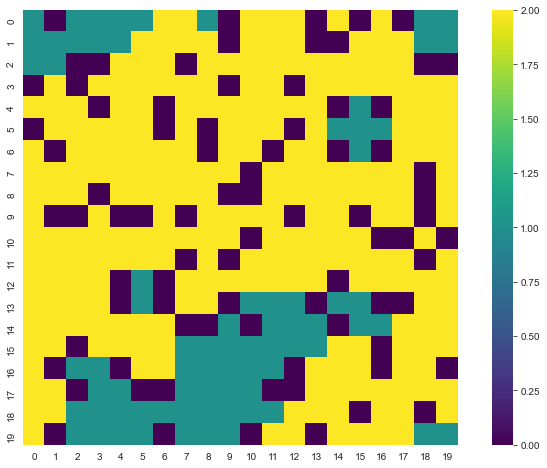

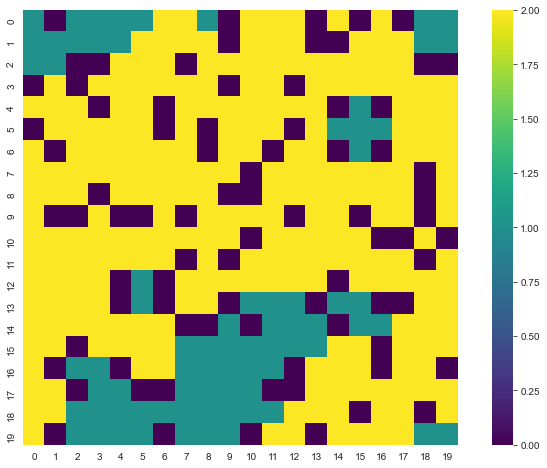

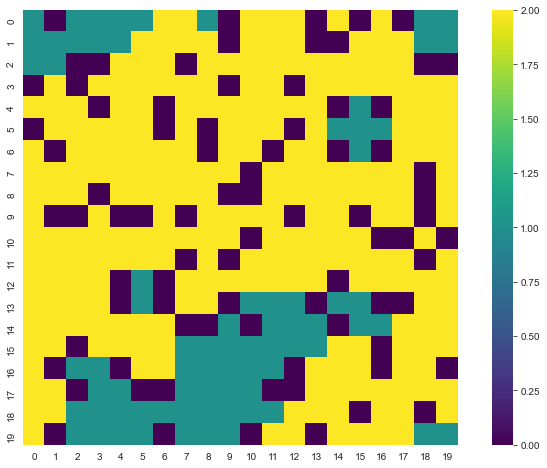

In [21]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_model(model):
    data = np.zeros((model.grid.width, model.grid.height),)

    fig, ax = plt.subplots()
    
    for (cell, i,j) in model.grid.coord_iter():
        if cell:
            data[i,j] = cell.color.value
    sns.heatmap(data, cmap='viridis', ax=ax)
    ax.set_aspect('equal')
    

for _ in range(10):
    model.step()
    plot_model(model)
    plt.show()

In [19]:
model.datacollector.get_model_vars_dataframe()

,happy
0,250
1,259
2,270
3,279
4,284
5,290
6,289
7,291
8,302
9,306
